# 05 - Regularización

**Objetivo:** Aplicar técnicas de regularización (Ridge, Lasso, Elastic Net) y comparar con el modelo de regresión lineal base.

**Técnicas:** Ridge (L2), Lasso (L1), Elastic Net (L1+L2)

In [1]:
import pandas as pd
import numpy as np
import joblib
import json
import os
import zipfile
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## 1. Cargar Datos

In [2]:
# Cargar datos de entrenamiento y test
df_train = pd.read_csv('../01_preprocessing_results/preprocessing/T_train_final_objetivo.csv')
df_test = pd.read_csv('../01_preprocessing_results/preprocessing/T_test_final_objetivo.csv')

# Separar features y objetivo
X_train = df_train.drop(columns=['objetivo'])
y_train = df_train['objetivo']
X_test = df_test.drop(columns=['objetivo'])
y_test = df_test['objetivo']

feature_names = X_train.columns.tolist()

print(f"Datos de entrenamiento: {X_train.shape[0]} muestras, {X_train.shape[1]} features")
print(f"Datos de test: {X_test.shape[0]} muestras")

Datos de entrenamiento: 54750 muestras, 20 features
Datos de test: 18250 muestras


## 2. Entrenar Modelos Regularizados con Validación Cruzada

In [3]:
# Definir rango de alphas a probar
alphas = np.logspace(-4, 4, 50)

print("Entrenando modelos con validación cruzada (5-fold)...\n")

Entrenando modelos con validación cruzada (5-fold)...



In [4]:
# Regresión Lineal base (sin regularización)
reg_lineal = LinearRegression()
reg_lineal.fit(X_train, y_train)
print("Regresión Lineal base entrenada")

Regresión Lineal base entrenada


In [5]:
# Ridge Regression (L2)
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)
print(f"Ridge - Mejor alpha: {ridge.alpha_:.6f}")

Ridge - Mejor alpha: 24.420531


In [6]:
# Lasso Regression (L1)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso.fit(X_train, y_train)
print(f"Lasso - Mejor alpha: {lasso.alpha_:.6f}")

Lasso - Mejor alpha: 0.126486


In [7]:
# Elastic Net (L1 + L2)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95], cv=5, max_iter=10000, random_state=42)
elastic.fit(X_train, y_train)
print(f"Elastic Net - Mejor alpha: {elastic.alpha_:.6f}, l1_ratio: {elastic.l1_ratio_:.2f}")

Elastic Net - Mejor alpha: 0.086851, l1_ratio: 0.95


## 3. Calcular Métricas

In [8]:
def calcular_metricas(modelo, X, y, nombre):
    """Calcula R², RMSE y MAE"""
    y_pred = modelo.predict(X)
    return {
        'Modelo': nombre,
        'R²': r2_score(y, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
        'MAE': mean_absolute_error(y, y_pred)
    }

In [9]:
# Calcular métricas para todos los modelos
metricas = [
    calcular_metricas(reg_lineal, X_test, y_test, 'Reg. Lineal (base)'),
    calcular_metricas(ridge, X_test, y_test, 'Ridge (L2)'),
    calcular_metricas(lasso, X_test, y_test, 'Lasso (L1)'),
    calcular_metricas(elastic, X_test, y_test, 'Elastic Net')
]

df_metricas = pd.DataFrame(metricas).set_index('Modelo').round(4)

print("\n" + "="*60)
print("COMPARACIÓN: REGRESIÓN LINEAL vs MODELOS REGULARIZADOS")
print("="*60)
print(df_metricas.to_string())
print("="*60)

# Guardar comparación
df_metricas.to_csv('comparacion_regularizacion.csv')
print("\nGuardado: comparacion_regularizacion.csv")


COMPARACIÓN: REGRESIÓN LINEAL vs MODELOS REGULARIZADOS
                        R²     RMSE      MAE
Modelo                                      
Reg. Lineal (base)  0.7772  51.4784  41.2284
Ridge (L2)          0.7772  51.4783  41.2270
Lasso (L1)          0.7772  51.4728  41.2196
Elastic Net         0.7772  51.4741  41.2086

Guardado: comparacion_regularizacion.csv


## 4. Coeficientes de los Modelos

In [10]:
# Crear DataFrame con coeficientes de todos los modelos
coeficientes = pd.DataFrame({
    'Feature': feature_names,
    'Reg_Lineal': reg_lineal.coef_,
    'Ridge': ridge.coef_,
    'Lasso': lasso.coef_,
    'ElasticNet': elastic.coef_
})

# Agregar interceptos
interceptos = pd.DataFrame({
    'Feature': ['Intercept'],
    'Reg_Lineal': [reg_lineal.intercept_],
    'Ridge': [ridge.intercept_],
    'Lasso': [lasso.intercept_],
    'ElasticNet': [elastic.intercept_]
})

coeficientes = pd.concat([interceptos, coeficientes], ignore_index=True)
coeficientes.to_csv('coeficientes_modelos.csv', index=False)

print("Coeficientes de los modelos:")
print(coeficientes.round(4).to_string(index=False))
print("\nGuardado: coeficientes_modelos.csv")

Coeficientes de los modelos:
               Feature  Reg_Lineal    Ridge    Lasso  ElasticNet
             Intercept    141.6753 141.6753 141.5686    141.5717
                   PC1      1.5270   1.5267   1.4625      1.4814
                   PC2     76.8019  76.7802  76.7206     76.5388
                   PC3      0.7315   0.7311   0.6069      0.6478
                   PC4     -0.1343  -0.1343  -0.0089     -0.0521
                   PC5      0.3319   0.3318   0.2064      0.2493
   Category___clothing      0.1274   0.1272   0.0000      0.0000
Category___electronics      0.1774   0.1767   0.0000      0.0000
  Category___furniture      0.3100   0.3095   0.0000      0.0000
  Category___groceries     -0.0348  -0.0346  -0.0000     -0.0000
       Category___toys     -0.5800  -0.5788  -0.0000     -0.2090
         Region___east     -0.3958  -0.3949  -0.0000     -0.0000
        Region___north     -0.4680  -0.4670  -0.0000     -0.0000
        Region___south      0.0412   0.0412   0.0000      0.0

In [11]:
# Betas pre y post regularización (solo variables numéricas PCA)
pca_cols = [col for col in feature_names if col.startswith('PC')]

betas_pca = pd.DataFrame({
    'Feature': pca_cols,
    'Beta_Pre_Reg (Lineal)': [reg_lineal.coef_[feature_names.index(col)] for col in pca_cols],
    'Beta_Post_Reg (ElasticNet)': [elastic.coef_[feature_names.index(col)] for col in pca_cols]
})

betas_pca.to_csv('betas_post_pre_numericas.csv', index=False)
print("Betas pre/post regularización (numéricas):")
print(betas_pca.round(4).to_string(index=False))
print("\nGuardado: betas_post_pre_numericas.csv")

Betas pre/post regularización (numéricas):
Feature  Beta_Pre_Reg (Lineal)  Beta_Post_Reg (ElasticNet)
    PC1                 1.5270                      1.4814
    PC2                76.8019                     76.5388
    PC3                 0.7315                      0.6478
    PC4                -0.1343                     -0.0521
    PC5                 0.3319                      0.2493

Guardado: betas_post_pre_numericas.csv


## 5. Visualización

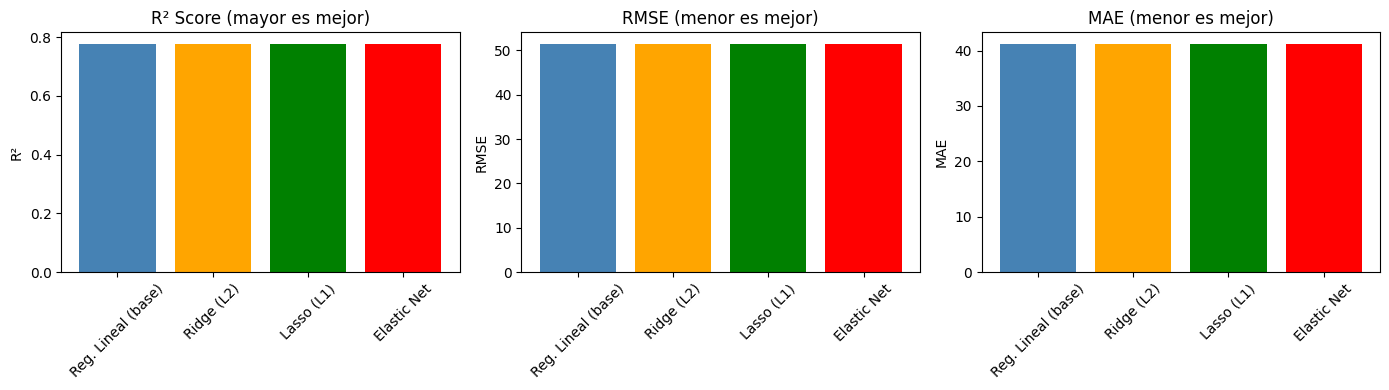

Gráfico guardado: comparacion_regularizacion.png


In [12]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

modelos = df_metricas.index.tolist()
colores = ['steelblue', 'orange', 'green', 'red']

# R²
axes[0].bar(modelos, df_metricas['R²'], color=colores)
axes[0].set_ylabel('R²')
axes[0].set_title('R² Score (mayor es mejor)')
axes[0].tick_params(axis='x', rotation=45)

# RMSE
axes[1].bar(modelos, df_metricas['RMSE'], color=colores)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE (menor es mejor)')
axes[1].tick_params(axis='x', rotation=45)

# MAE
axes[2].bar(modelos, df_metricas['MAE'], color=colores)
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE (menor es mejor)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('comparacion_regularizacion.png', dpi=150)
plt.show()

print("Gráfico guardado: comparacion_regularizacion.png")

## 6. Selección y Guardado del Mejor Modelo

In [13]:
# Encontrar el mejor modelo regularizado (excluyendo base)
df_regularizados = df_metricas.drop('Reg. Lineal (base)')
mejor_modelo_nombre = df_regularizados['R²'].idxmax()
mejor_r2 = df_regularizados.loc[mejor_modelo_nombre, 'R²']

print(f"\n>>> MEJOR MODELO REGULARIZADO: {mejor_modelo_nombre} (R² = {mejor_r2:.4f}) <<<")

# Mapear nombre a objeto
modelos_dict = {
    'Ridge (L2)': ridge,
    'Lasso (L1)': lasso,
    'Elastic Net': elastic
}

mejor_modelo = modelos_dict[mejor_modelo_nombre]


>>> MEJOR MODELO REGULARIZADO: Ridge (L2) (R² = 0.7772) <<<


In [14]:
# Crear estructura de carpetas
os.makedirs('reg_lin_ganador/reg_lin_ganador_bundle', exist_ok=True)

# Guardar modelo
modelo_filename = 'modelo_elasticnet.pkl'
joblib.dump(mejor_modelo, f'reg_lin_ganador/reg_lin_ganador_bundle/{modelo_filename}')

# Crear metadata
metadata = {
    'modelo': mejor_modelo_nombre,
    'alpha': float(mejor_modelo.alpha_) if hasattr(mejor_modelo, 'alpha_') else None,
    'l1_ratio': float(mejor_modelo.l1_ratio_) if hasattr(mejor_modelo, 'l1_ratio_') else None,
    'r2_score': float(mejor_r2),
    'rmse': float(df_regularizados.loc[mejor_modelo_nombre, 'RMSE']),
    'mae': float(df_regularizados.loc[mejor_modelo_nombre, 'MAE']),
    'features': feature_names,
    'saved_at': time.strftime('%Y-%m-%d %H:%M:%S')
}

with open('reg_lin_ganador/reg_lin_ganador_bundle/metadata_modelo.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Modelo guardado: reg_lin_ganador/reg_lin_ganador_bundle/{modelo_filename}")
print("Metadata guardada: reg_lin_ganador/reg_lin_ganador_bundle/metadata_modelo.json")

Modelo guardado: reg_lin_ganador/reg_lin_ganador_bundle/modelo_elasticnet.pkl
Metadata guardada: reg_lin_ganador/reg_lin_ganador_bundle/metadata_modelo.json


In [15]:
# Crear ZIP del bundle
with zipfile.ZipFile('reg_lin_ganador/reg_lin_ganador_bundle.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(f'reg_lin_ganador/reg_lin_ganador_bundle/{modelo_filename}', modelo_filename)
    zipf.write('reg_lin_ganador/reg_lin_ganador_bundle/metadata_modelo.json', 'metadata_modelo.json')

print("ZIP creado: reg_lin_ganador/reg_lin_ganador_bundle.zip")

ZIP creado: reg_lin_ganador/reg_lin_ganador_bundle.zip


## 7. Conclusión

In [16]:
print("\n" + "="*60)
print("CONCLUSIÓN")
print("="*60)

r2_base = df_metricas.loc['Reg. Lineal (base)', 'R²']
r2_ridge = df_metricas.loc['Ridge (L2)', 'R²']
r2_lasso = df_metricas.loc['Lasso (L1)', 'R²']
r2_elastic = df_metricas.loc['Elastic Net', 'R²']

print(f"\nRegresión Lineal base: R² = {r2_base:.4f}")
print(f"Ridge (L2): R² = {r2_ridge:.4f} (diferencia: {(r2_ridge - r2_base)*100:+.2f}%)")
print(f"Lasso (L1): R² = {r2_lasso:.4f} (diferencia: {(r2_lasso - r2_base)*100:+.2f}%)")
print(f"Elastic Net: R² = {r2_elastic:.4f} (diferencia: {(r2_elastic - r2_base)*100:+.2f}%)")

print(f"\n>>> Mejor modelo regularizado: {mejor_modelo_nombre} <<<")
print("="*60)


CONCLUSIÓN

Regresión Lineal base: R² = 0.7772
Ridge (L2): R² = 0.7772 (diferencia: +0.00%)
Lasso (L1): R² = 0.7772 (diferencia: +0.00%)
Elastic Net: R² = 0.7772 (diferencia: +0.00%)

>>> Mejor modelo regularizado: Ridge (L2) <<<
